In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms

from collections import Counter

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

# Prepare the data

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [6]:
train_dataset = torchvision.datasets.ImageFolder("trafic_32", transform=transform)

In [7]:
len(train_dataset.classes)

43

## Split dataset

In [8]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [9]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=True)

In [10]:
next(iter(train_loader))[0][0].shape # size of image

torch.Size([3, 32, 32])

In [11]:
next(iter(train_loader))[0][0].max()

tensor(1.)

In [12]:
next(iter(train_loader))[0][0].min()

tensor(-1.)

## Show some random images from dataset

In [13]:
def get_train_images(num):
    return torch.stack([val_set[i][0] for i in range(10,10+num)], dim=0)

c:\users\bartosz\dataspellprojects\pytorch-neural-networks\venv\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


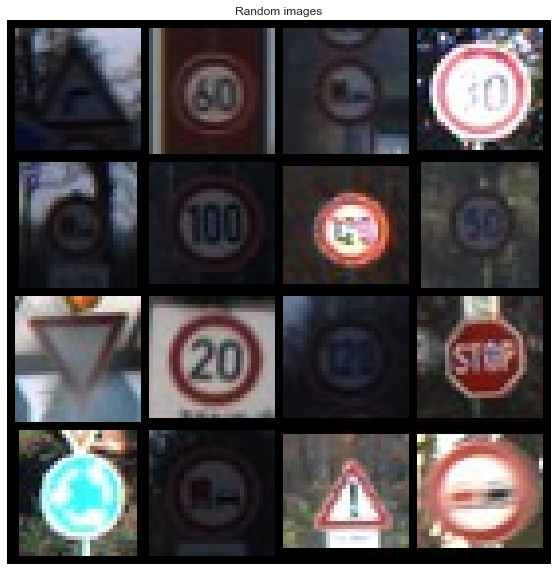

In [14]:
imgs = get_train_images(16)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(15,10))
plt.title(f"Random images")
plt.imshow(grid)
plt.axis('off')
plt.show()

# CondVAE

In [15]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3+1, out_channels=64+1, kernel_size=(3,3), padding=1, stride=(2,2)), # -> 16x16x65
            nn.BatchNorm2d(64+1, 0.9),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64+1, out_channels=128+1, kernel_size=(3,3), padding=1, stride=(2,2)) , # -> 8x8x129
            nn.BatchNorm2d(128+1, 0.9),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128+1, out_channels=256+1, kernel_size=(3,3), padding=1, stride=(2,2)), # -> 4x4x257
            nn.BatchNorm2d(256+1, 0.9),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256+1, out_channels=512+1, kernel_size=(3,3), padding=1, stride=(2,2)), # -> 2x2x513
            nn.BatchNorm2d(512+1, 0.9),
            nn.LeakyReLU(0.2),
        )
        self.fc_mean  = nn.Linear(2052, latent_dim)
        self.fc_var   = nn.Linear(2052, latent_dim)

    def forward(self, x):
        x = self.net(x)
        x = torch.flatten(x, 1) # 2052
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)

        return mean, log_var

In [16]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Decoder, self).__init__()

        self.fc = nn.Linear(latent_dim + num_classes, 2048)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3,3), padding=(1,1), stride=(2,2), output_padding=(1,1)), # -> 4x4x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=(1,1), stride=(2,2), output_padding=(1,1)), # -> 8x8x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=(1,1), stride=(2,2), output_padding=(1,1)), # -> 16x16x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=(1,1), stride=(2,2), output_padding=(1,1)), # -> 32x32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3,3), padding=1), # -> 32x32x3
            nn.Tanh()
        )

    def forward(self, x):
        x_hat = self.fc(x)
        x_hat = x_hat.view([-1, 512, 2, 2])
        x_hat = self.net(x_hat)
        return x_hat

In [17]:
class VAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.embed_class = nn.Linear(num_classes, 32 * 32)
        self.embed_data = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1))

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, num_classes=num_classes)


    def reparameterization(self, mean, var):
        z = torch.randn_like(mean) * var + mean
        return z

    def forward(self, x, c):
        embedded_class = self.embed_class(c)
        embedded_class = embedded_class.view(-1, 32, 32).unsqueeze(1)
        embedded_input = self.embed_data(x)

        x = torch.cat([embedded_input, embedded_class], dim=1)
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(torch.cat([z,c], dim=1))

        return x_hat, mean, log_var

In [18]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [19]:
def plot_training(iters, losses, l1_losses):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

    ax[0].plot(iters, losses)
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(iters, l1_losses)
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('L1 loss')

In [20]:
def generate_images_for_class(vae, n_imgs, y, device):
    c = F.one_hot(torch.full(size=(n_imgs,), fill_value=y), len(train_dataset.classes)).to(device).float()
    generated_imgs = vae.decoder(torch.cat([torch.randn([n_imgs, vae.latent_dim]).to(device), c], dim=1))
    return generated_imgs.cpu()

In [21]:
def plot_generated_images(generated_images, c):
    grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True, range=(-1,1))
    grid = grid.permute(1,2,0)
    plt.figure(figsize=(15,10))
    plt.title(f"Generations of class {c}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [22]:
def plot_classes_generations(vae):
    for i in range(len(train_dataset.classes)-1):
        c = F.one_hot(torch.full(size=(8,), fill_value=i), len(train_dataset.classes)).to(device).float()
        generated_imgs = vae.decoder(torch.cat([torch.randn([8, vae.latent_dim]).to(device), c], dim=1))
        generated_imgs = generated_imgs.cpu()
        plot_generated_images(generated_imgs, i)

In [23]:
LR = 0.0002
LATENT_DIM = 128
EPOCHS=70

In [27]:
vae = VAE(latent_dim=LATENT_DIM, num_classes=len(train_dataset.classes)).to(device)

In [28]:
optimizer = optim.Adam(vae.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

[1/70] loss: 21737.924 test L1: 0.176
[2/70] loss: 13116.292 test L1: 0.153
[3/70] loss: 11262.937 test L1: 0.141
[4/70] loss: 10176.906 test L1: 0.133
[5/70] loss: 9563.893 test L1: 0.128
[6/70] loss: 9078.927 test L1: 0.123
[7/70] loss: 8756.660 test L1: 0.121
[8/70] loss: 8510.228 test L1: 0.119
[9/70] loss: 8308.247 test L1: 0.117
[10/70] loss: 8138.667 test L1: 0.115
[11/70] loss: 8018.307 test L1: 0.114
[12/70] loss: 7874.160 test L1: 0.113
[13/70] loss: 7753.659 test L1: 0.112
[14/70] loss: 7675.320 test L1: 0.113
[15/70] loss: 7580.887 test L1: 0.110
[16/70] loss: 7509.435 test L1: 0.110
[17/70] loss: 7433.553 test L1: 0.108
[18/70] loss: 7355.097 test L1: 0.109
[19/70] loss: 7309.827 test L1: 0.110
[20/70] loss: 7232.309 test L1: 0.108
[21/70] loss: 7189.405 test L1: 0.107
[22/70] loss: 7135.076 test L1: 0.106
[23/70] loss: 7078.271 test L1: 0.106
[24/70] loss: 7039.899 test L1: 0.105
[25/70] loss: 6994.371 test L1: 0.105
[26/70] loss: 6945.544 test L1: 0.104
[27/70] loss: 692

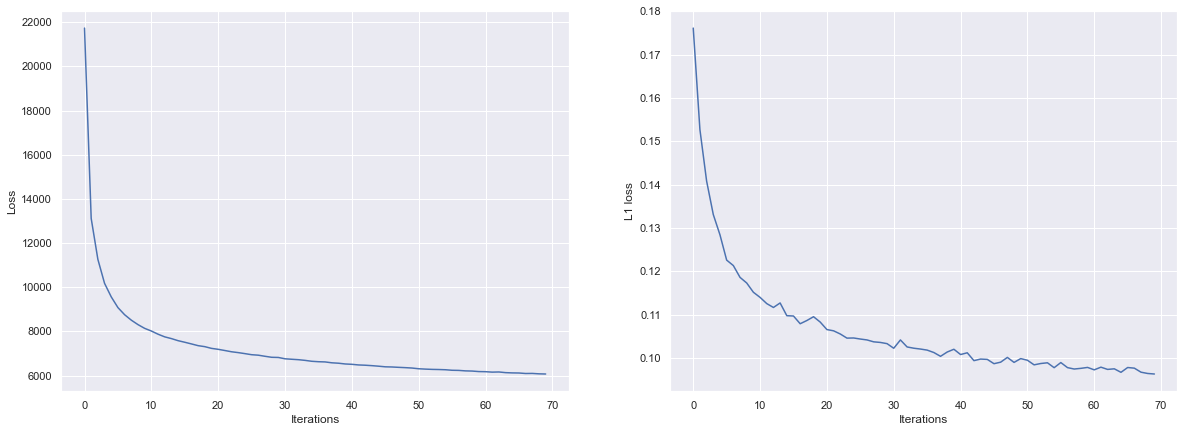

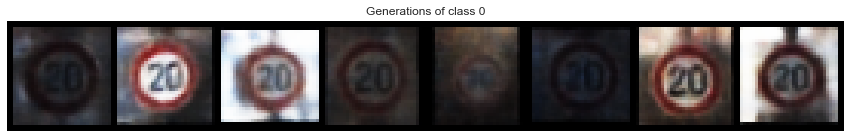

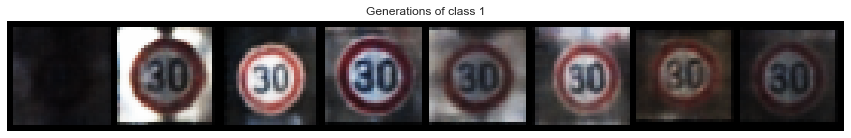

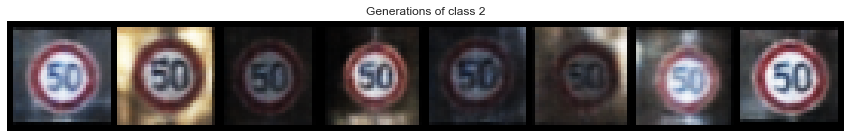

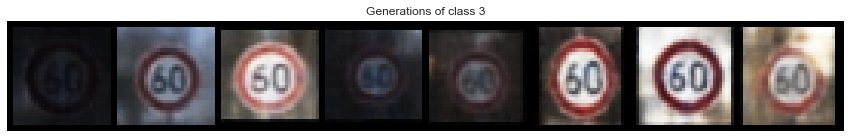

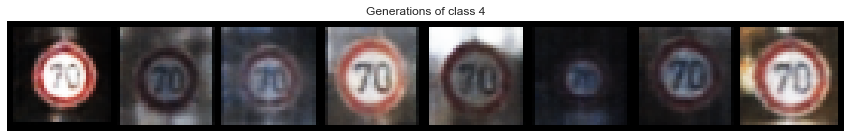

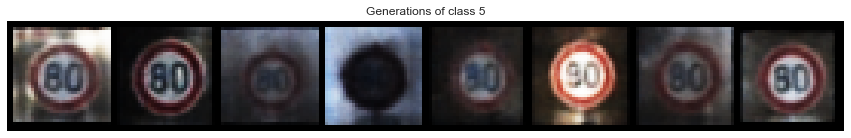

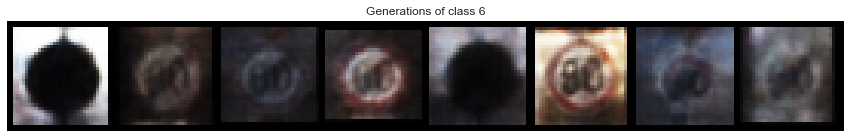

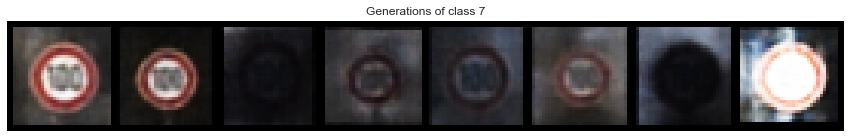

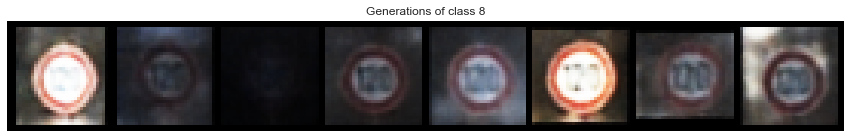

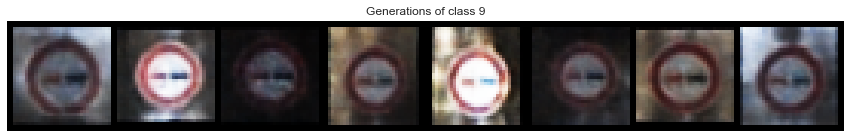

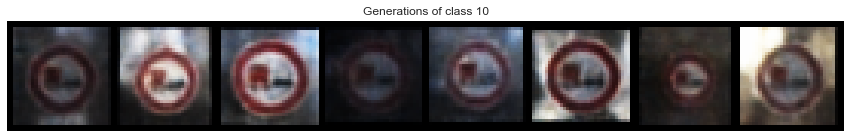

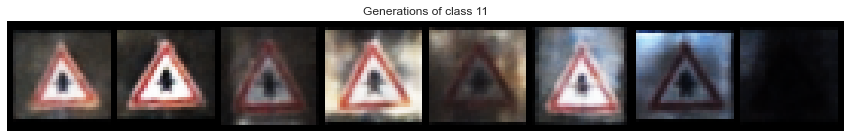

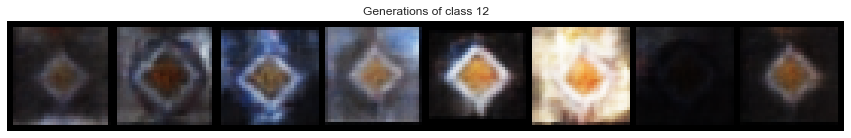

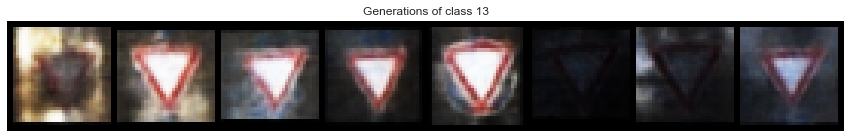

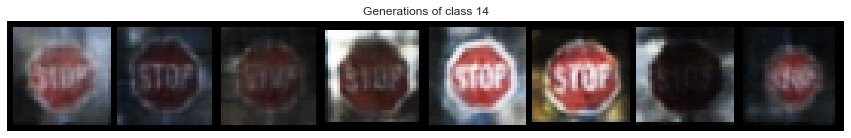

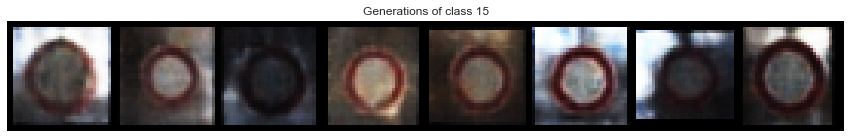

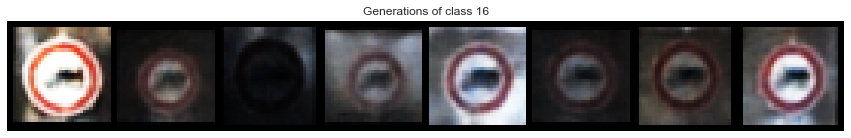

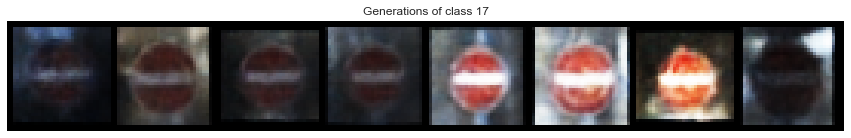

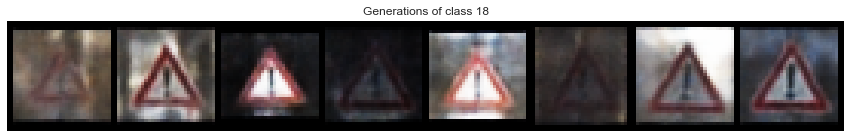

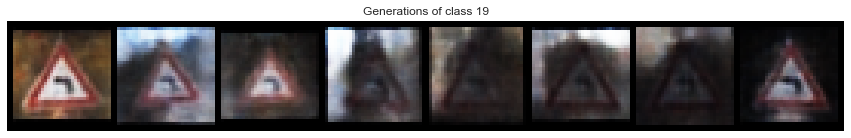

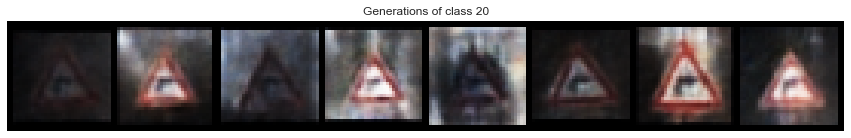

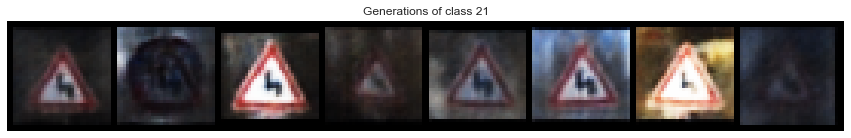

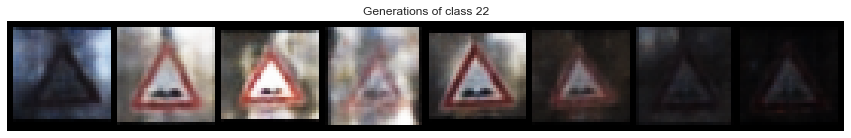

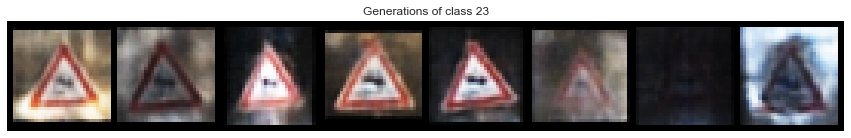

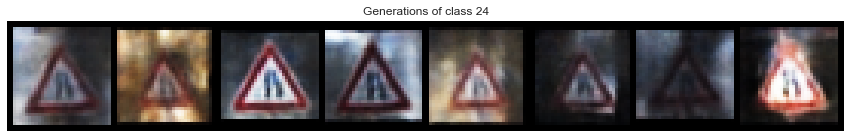

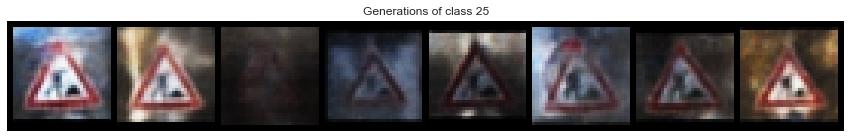

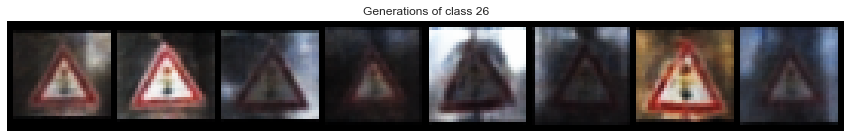

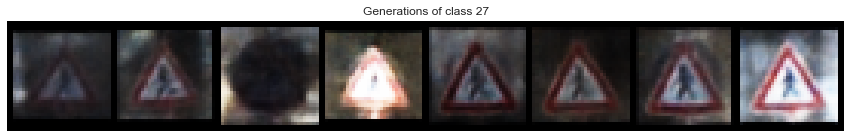

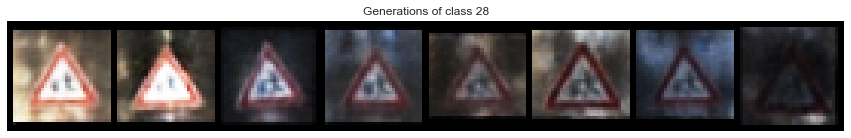

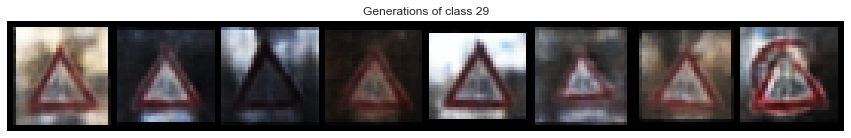

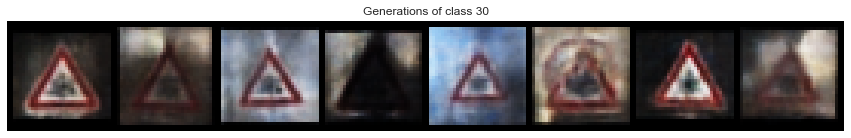

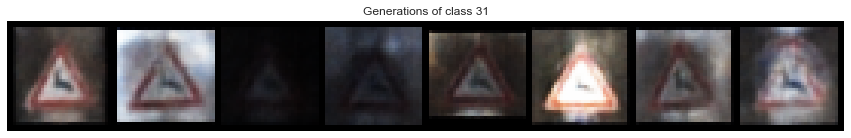

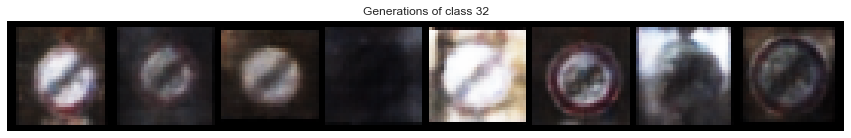

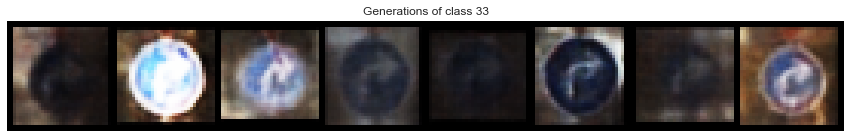

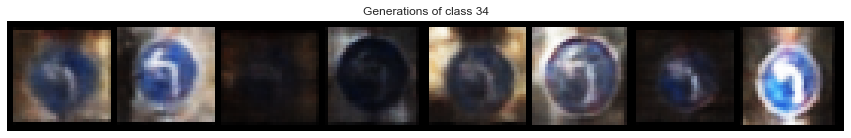

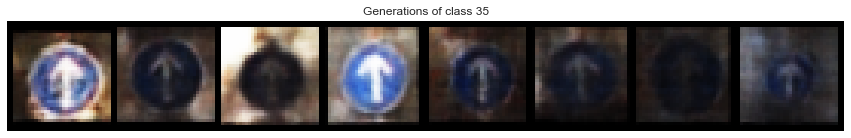

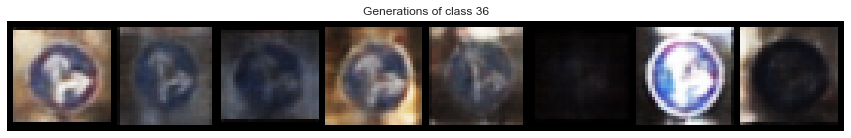

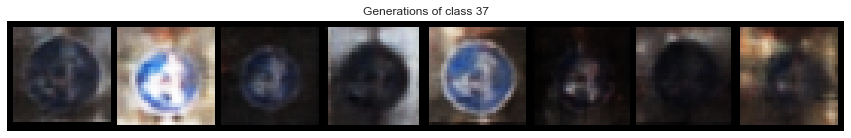

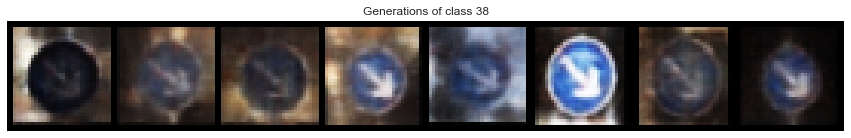

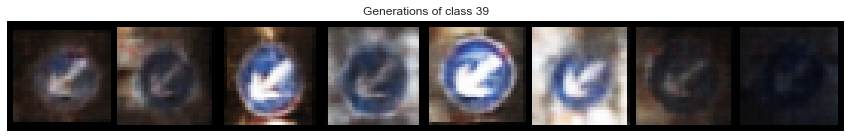

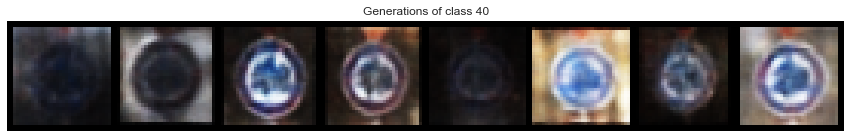

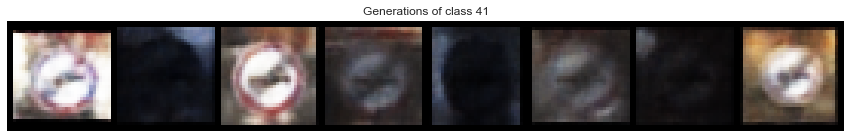

In [29]:
iters = []
losses = []
l1_losses = []

for epoch in range(EPOCHS):
    epoch_losses = []
    for x, y in iter(train_loader):
        x = x.to(device)
        c = F.one_hot(y, len(train_dataset.classes)).to(device).float()
        out, means, log_var = vae(x, c)
        loss = vae_loss_function(x, out, means, log_var)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    L1_list = []
    for x, y in iter(val_loader):
        x  = x.to(device)
        c = F.one_hot(y, len(train_dataset.classes)).to(device).float()
        out, _, _ = vae(x, c)
        L1_list.append(torch.mean(torch.abs(out-x)).item())

    iters.append(epoch)
    loss_mean = np.array(epoch_losses).mean()
    losses.append(loss_mean)
    l1_mean = np.mean(L1_list)
    l1_losses.append(l1_mean)

    print(f"[{epoch+1}/{EPOCHS}] loss: {loss_mean:.3f} test L1: {l1_mean:.3f}")
    scheduler.step()

print(f'Finished Training')

plot_training(iters, losses, l1_losses)
plot_classes_generations(vae)
torch.save(vae.state_dict(), f"weights/condVAE/condVAE2.pth") # save the model

# Load the model

In [30]:
vae = VAE(latent_dim=128, num_classes=len(train_dataset.classes)).to(device)
vae.load_state_dict(torch.load("weights/condVAE/condVAE2.pth"))

<All keys matched successfully>

# Generate random 1000 images

In [31]:
classes = [label for _, label in train_dataset]
classes_counter = Counter(classes)
classes_counter

Counter({0: 210,
         1: 2220,
         2: 2250,
         3: 1410,
         4: 1980,
         5: 1860,
         6: 420,
         7: 1440,
         8: 1410,
         9: 1470,
         10: 2010,
         11: 1320,
         12: 2100,
         13: 2160,
         14: 780,
         15: 630,
         16: 420,
         17: 1110,
         18: 1200,
         19: 210,
         20: 360,
         21: 330,
         22: 390,
         23: 510,
         24: 270,
         25: 1500,
         26: 600,
         27: 240,
         28: 540,
         29: 270,
         30: 450,
         31: 780,
         32: 240,
         33: 689,
         34: 420,
         35: 1200,
         36: 390,
         37: 210,
         38: 2070,
         39: 300,
         40: 360,
         41: 240,
         42: 240})

In [32]:
classes_ratio = dict()
for k,v in classes_counter.items():
    classes_ratio[k] = classes_counter[k]/sum(classes_counter.values())

In [33]:
sum(classes_ratio.values())

1.0

In [34]:
for k,v in classes_ratio.items():
    classes_ratio[k] =  round(classes_ratio[k]*1000)

In [35]:
classes_ratio

{0: 5,
 1: 57,
 2: 57,
 3: 36,
 4: 50,
 5: 47,
 6: 11,
 7: 37,
 8: 36,
 9: 37,
 10: 51,
 11: 34,
 12: 54,
 13: 55,
 14: 20,
 15: 16,
 16: 11,
 17: 28,
 18: 31,
 19: 5,
 20: 9,
 21: 8,
 22: 10,
 23: 13,
 24: 7,
 25: 38,
 26: 15,
 27: 6,
 28: 14,
 29: 7,
 30: 11,
 31: 20,
 32: 6,
 33: 18,
 34: 11,
 35: 31,
 36: 10,
 37: 5,
 38: 53,
 39: 8,
 40: 9,
 41: 6,
 42: 6}

In [36]:
sum(classes_ratio.values())

999

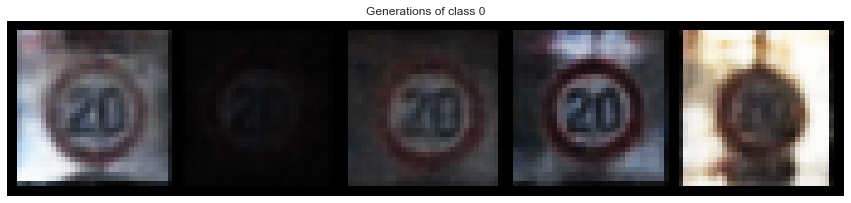

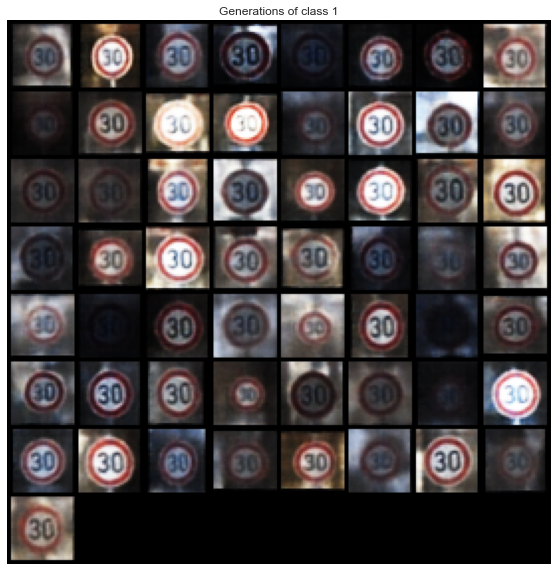

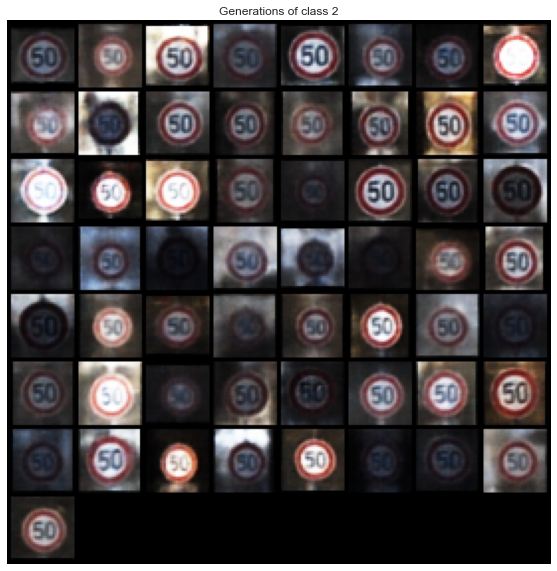

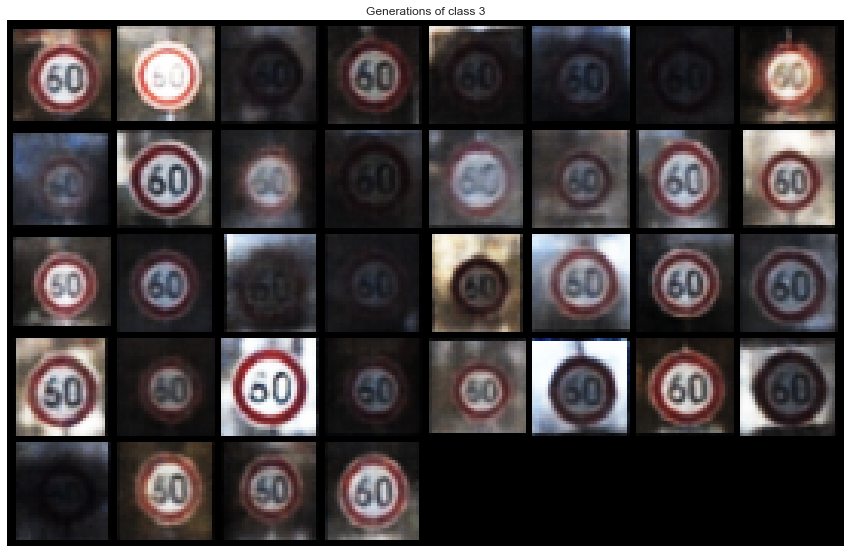

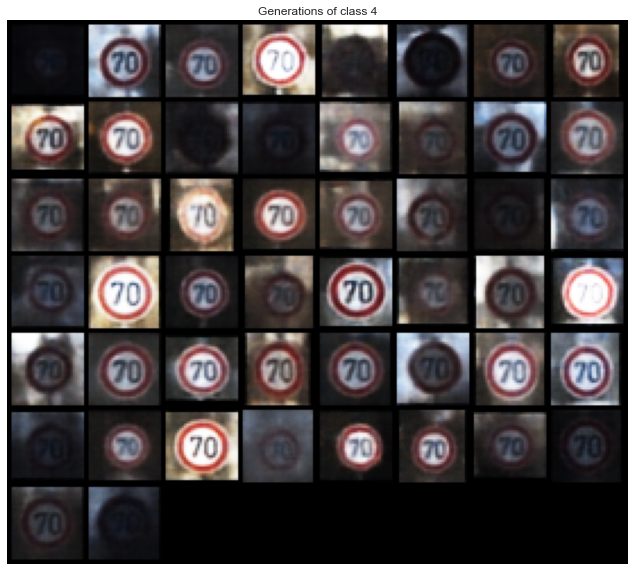

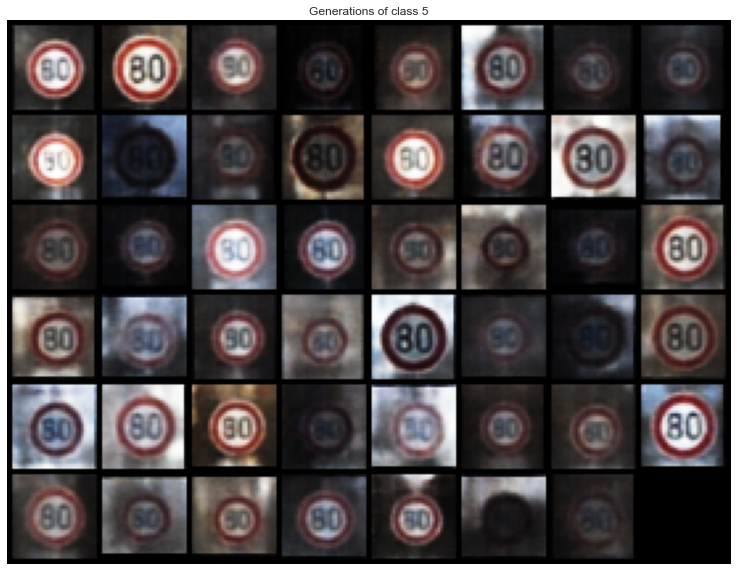

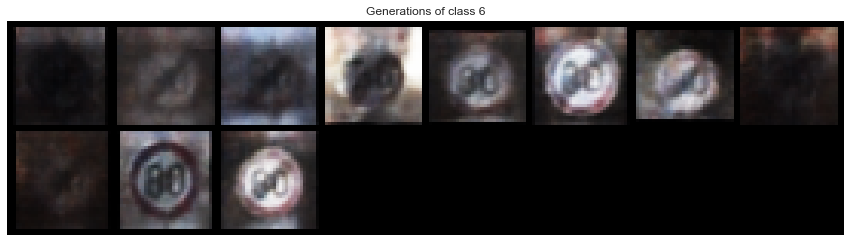

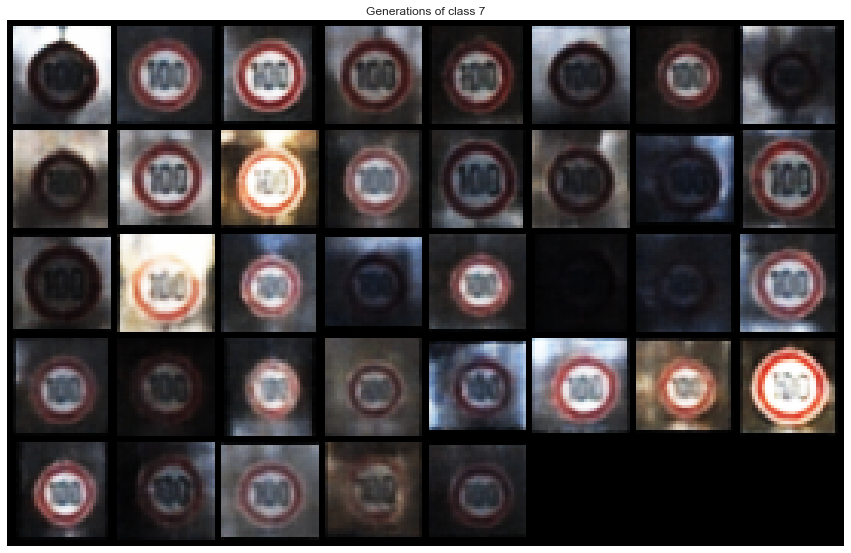

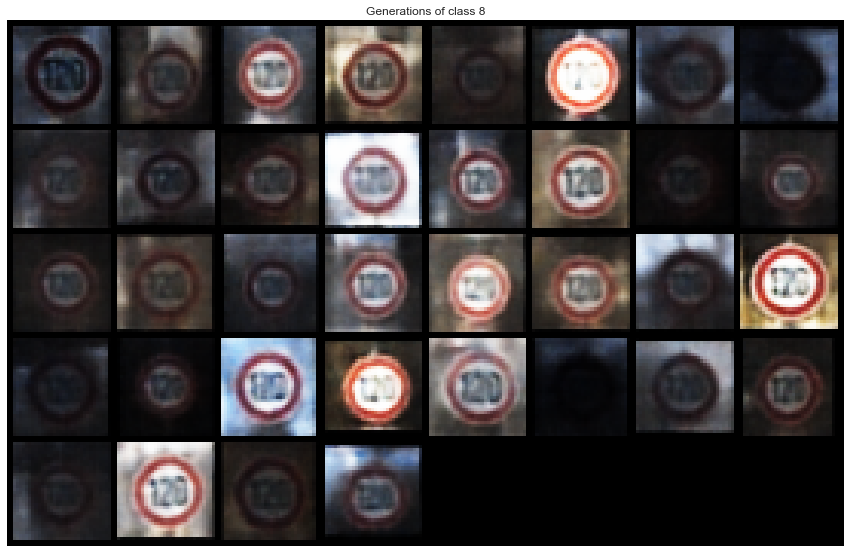

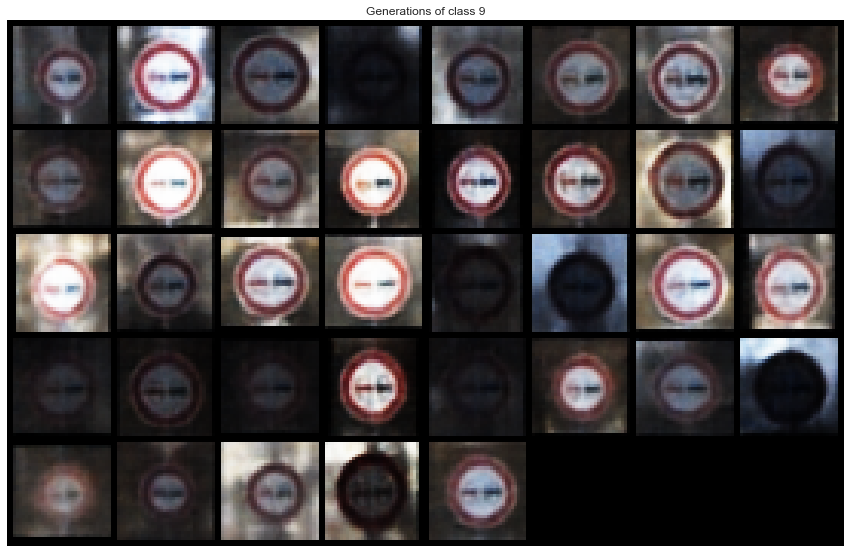

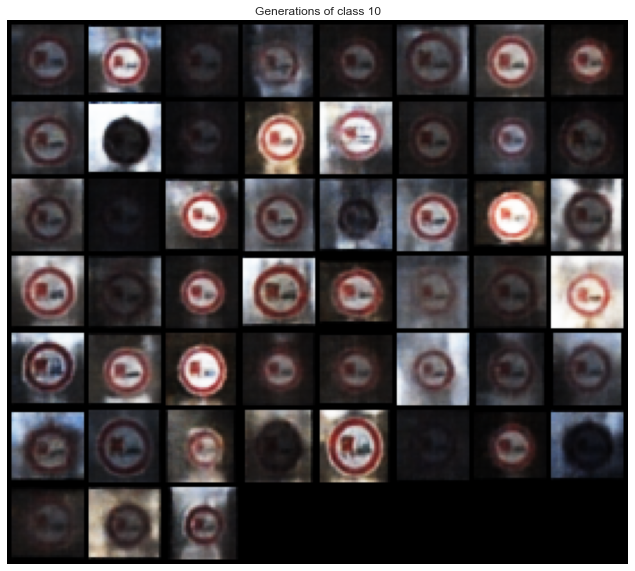

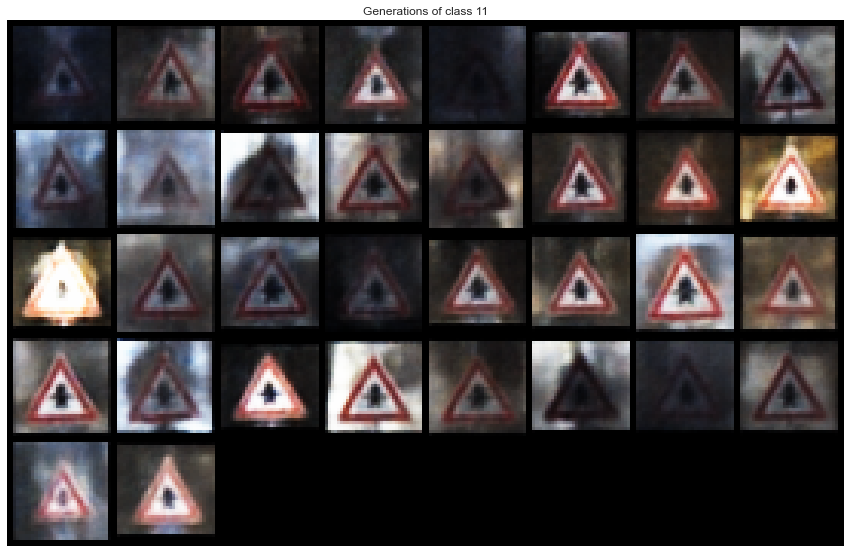

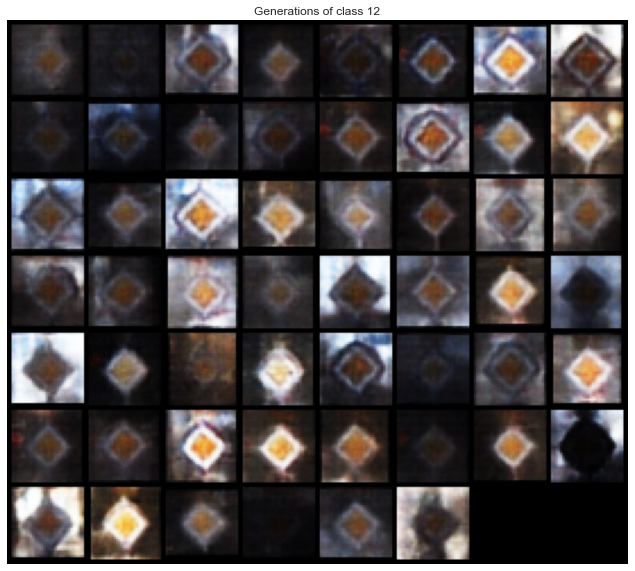

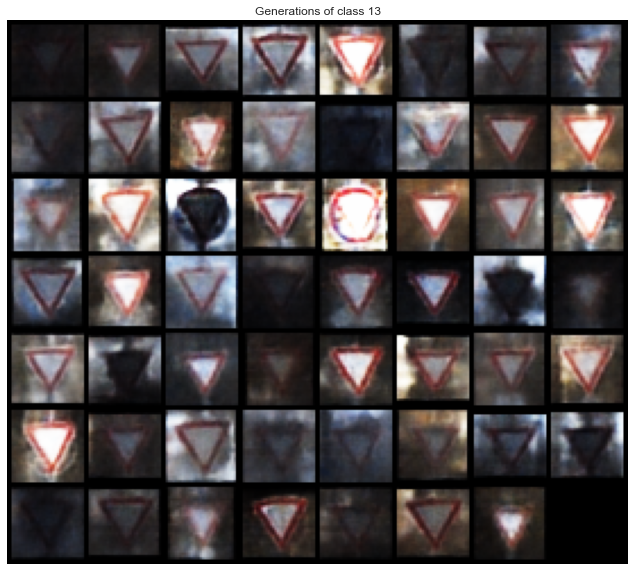

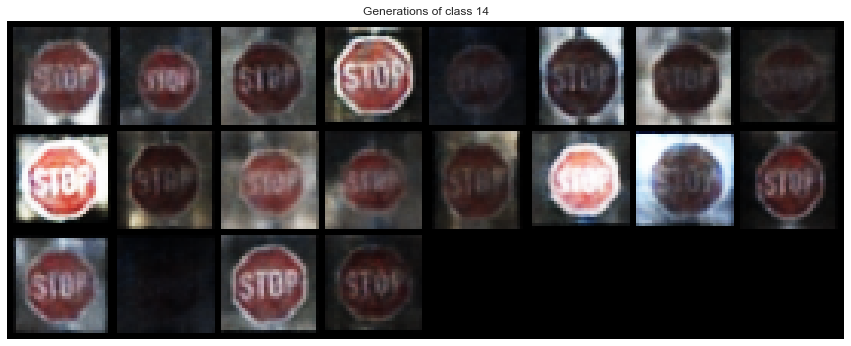

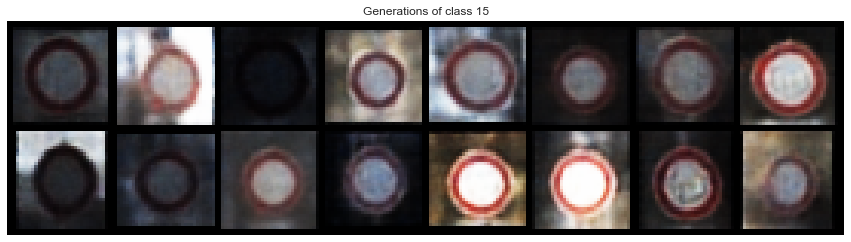

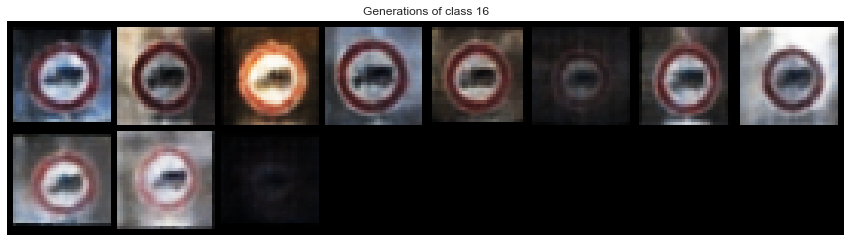

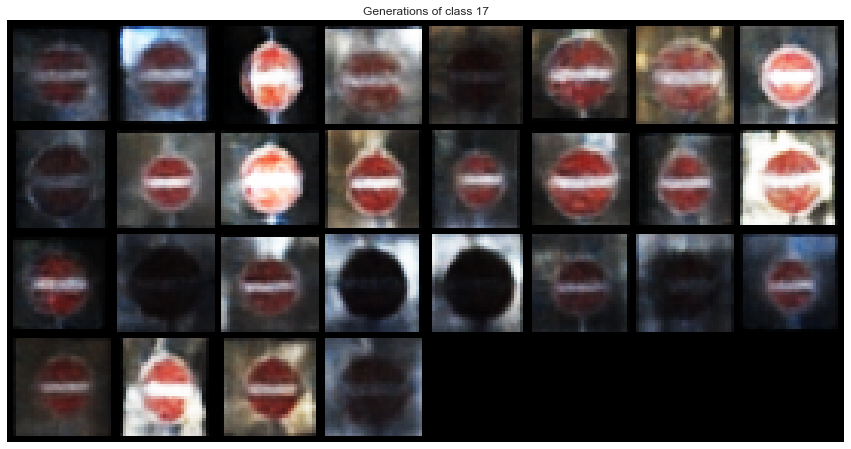

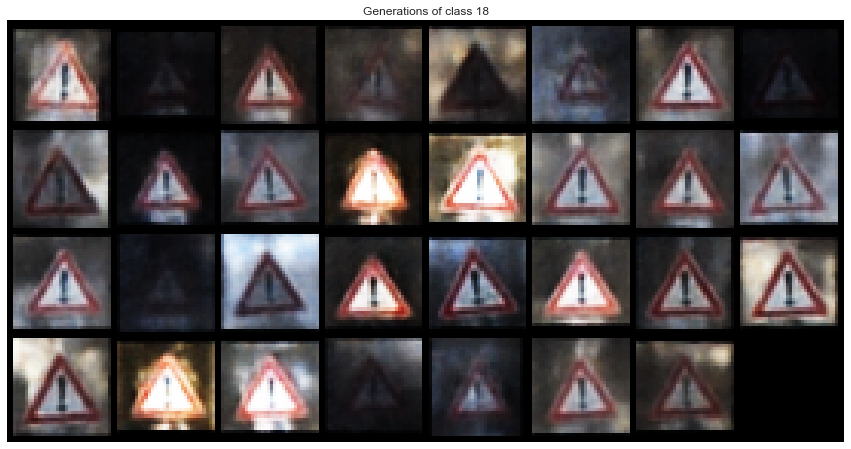

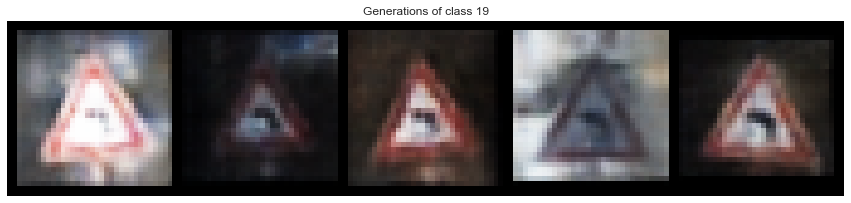

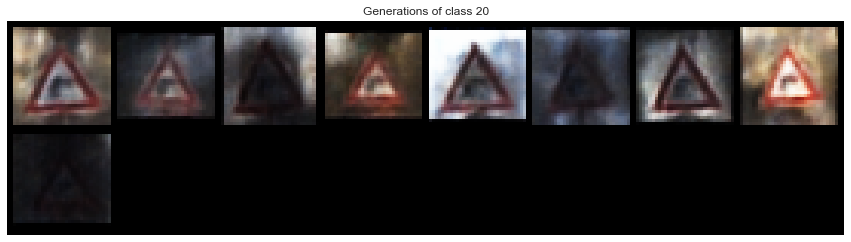

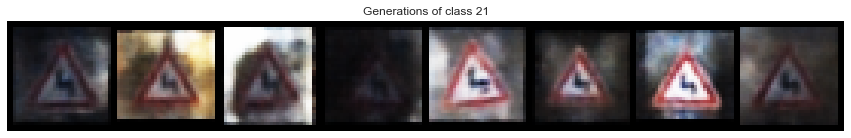

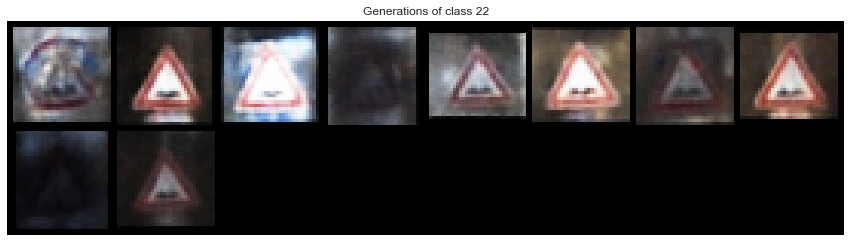

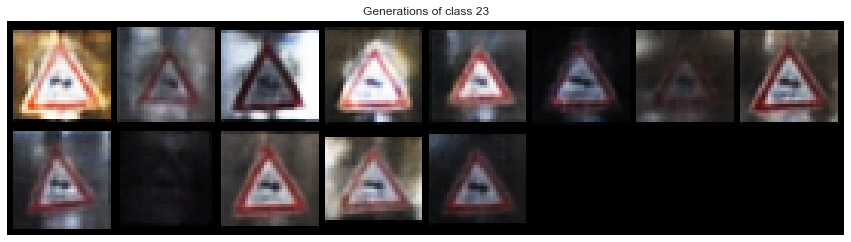

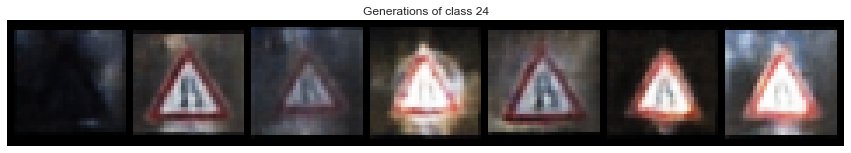

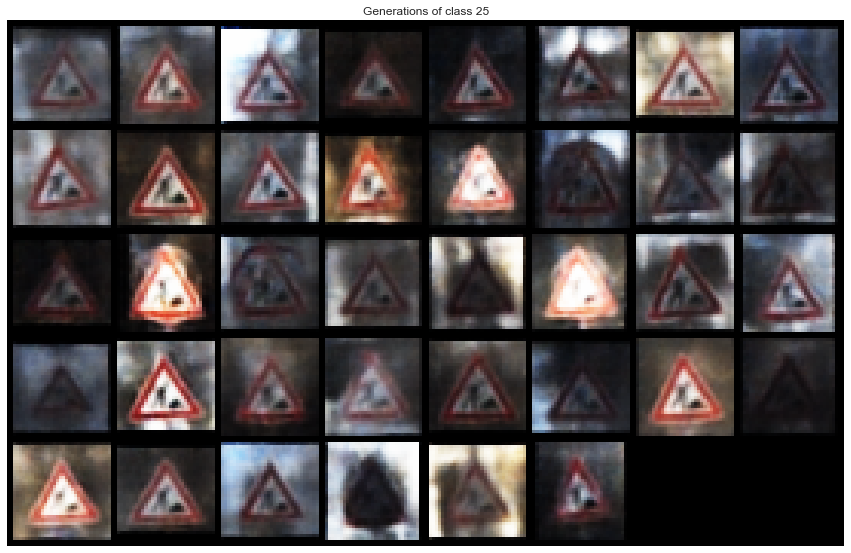

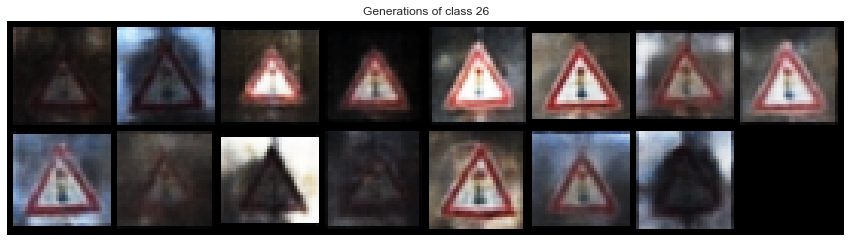

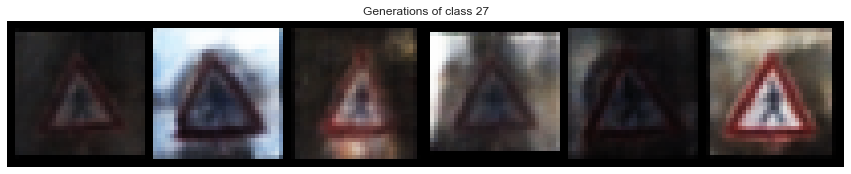

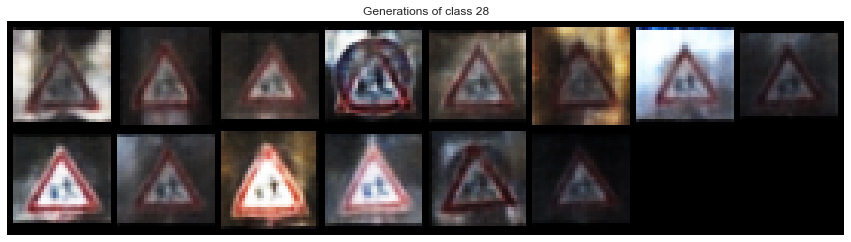

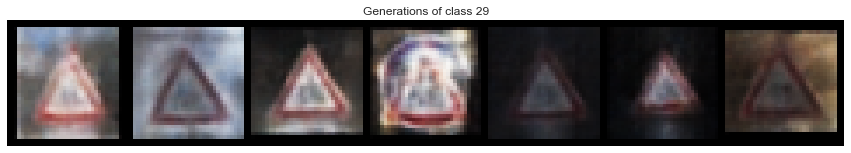

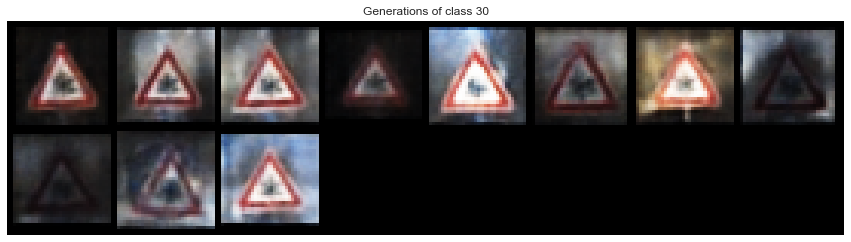

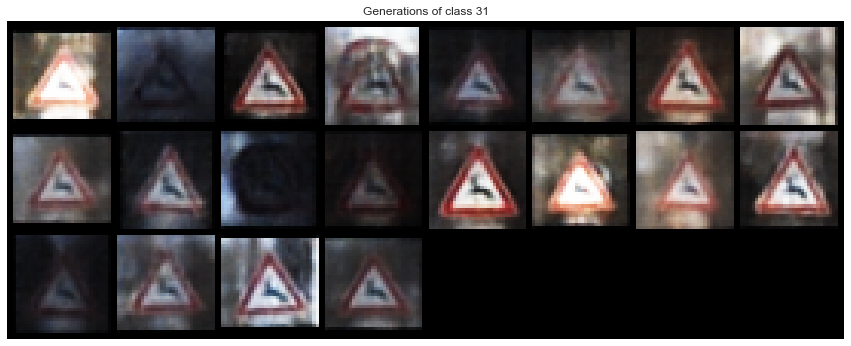

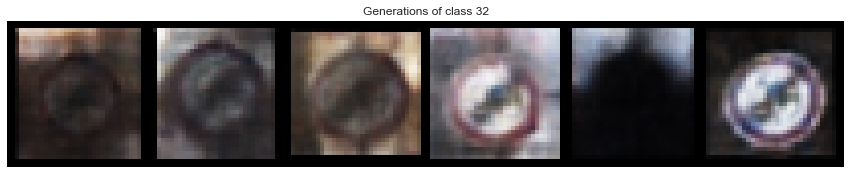

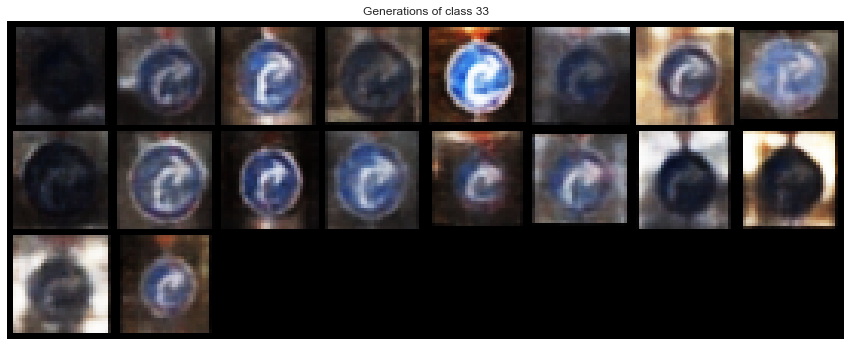

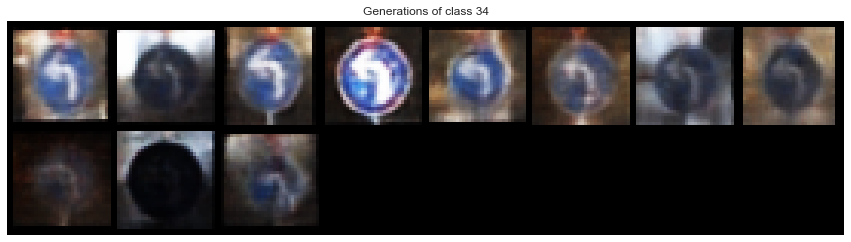

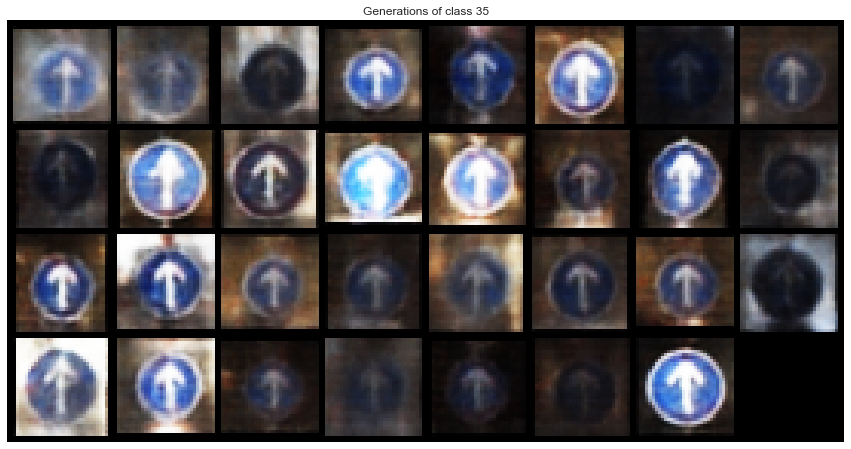

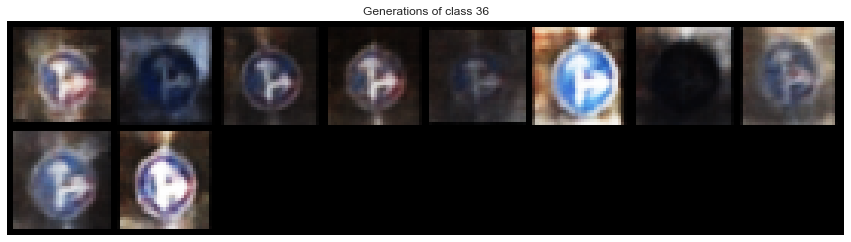

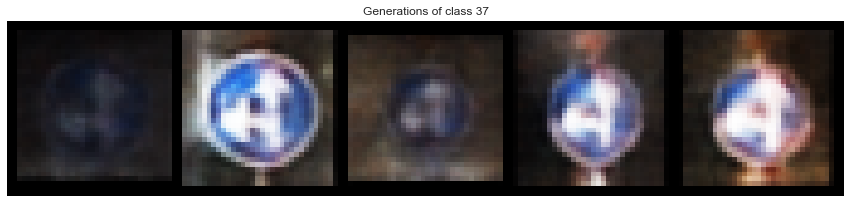

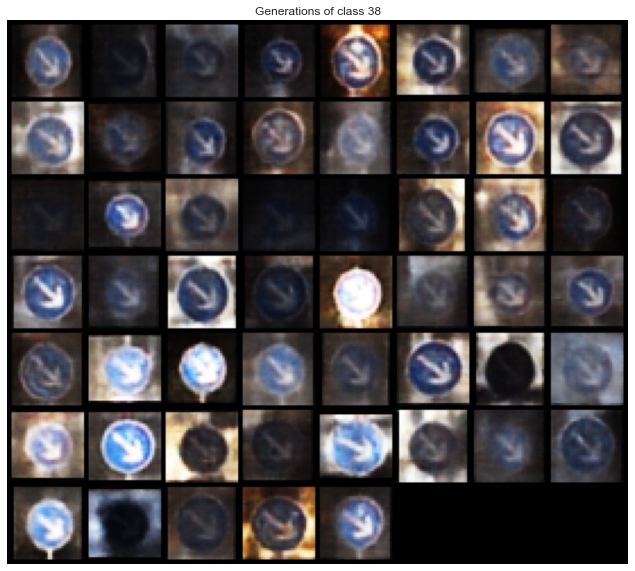

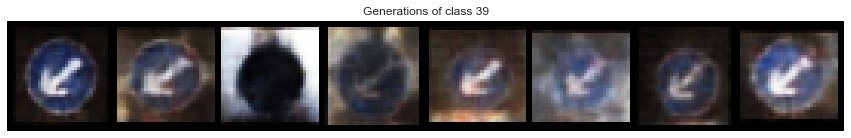

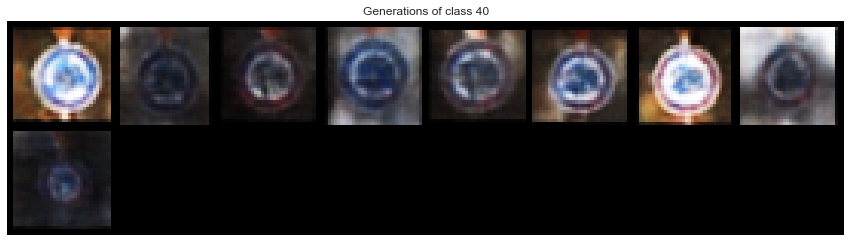

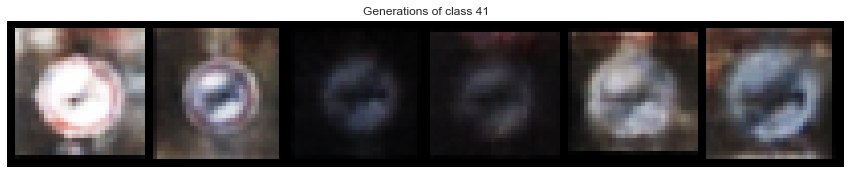

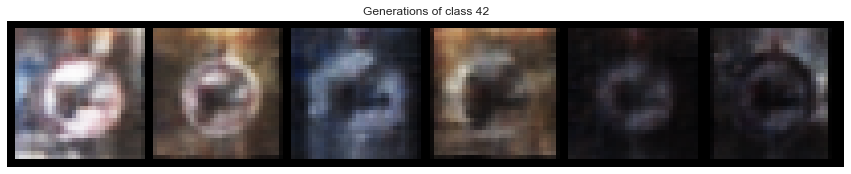

In [37]:
generated_images = generate_images_for_class(vae, 1, 0, device)
for c, n in classes_ratio.items():
    c_images = generate_images_for_class(vae, n, c, device)
    plot_generated_images(c_images, c)
    generated_images = torch.cat([generated_images, c_images], dim=0)

In [148]:
generated_images.shape

torch.Size([1000, 3, 32, 32])

# Denormalize back to [0,1]

In [166]:
generated_images = (generated_images * 0.5) + 0.5

In [170]:
torch.save(generated_images.detach(), "generations/poniedzialek_Cywinski_Rybarczyk2.pt")